In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

## Work with data
### Read data

Emodji and labels look like:
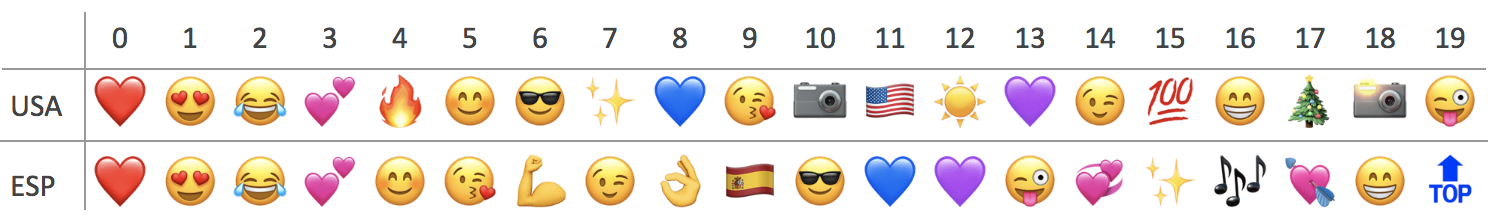

Read train data

In [2]:
with open('./data/data_us/tweet_by_ID_20_11_2017__03_39_34.txt.text', 'r') as f:
    texts = [l.strip() for l in f]

FileNotFoundError: [Errno 2] No such file or directory: './data/data_us/tweet_by_ID_20_11_2017__03_39_34.txt.text'

In [3]:
with open('./data/data_us/tweet_by_ID_20_11_2017__03_39_34.txt.labels', 'r') as f:
    labels = [int(l.strip()) for l in f]

In [4]:
with open('./data/data_us/tweet_by_ID_20_11_2017__03_39_34.txt.ids', 'r') as f:
    ids = [l.strip() for l in f]

Read trial data (only texts)

In [5]:
with open('./data/us_trial.text', 'r') as f:
    texts_trial = [l.strip() for l in f]

Read mapping for emodji and labels

In [18]:
with open('./labels/us_mapping.txt', 'r') as f:
    maps = [l.strip().split() for l in f]

In [7]:
emodji = [maps[l][1] for l in labels]

Look at the data

In [8]:
texts[:5]

['LoL @ West Covina, California',
 'Things got a little festive at the office #christmas2016 @ RedRock…',
 'Step out and explore. # ️ @ Ellis Island Cafe',
 '@user @ Cathedral Preparatory School',
 "My baby bear @ Bubby's"]

In [9]:
labels[:5]

[2, 17, 0, 18, 1]

In [10]:
emodji[:5]

['😂', '🎄', '❤', '📸', '😍']

### Preprocessing data
We clean our data from:
* URLS
* Punctiation
* Symbols '#' and '@'
* Stop-words

We also transform it into lowercase and use stemming.

In [11]:
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from string import punctuation
from nltk.stem.snowball import EnglishStemmer

In [12]:
p.set_options(p.OPT.URL)

In [13]:
translator = str.maketrans("", "", punctuation)
stemmer = EnglishStemmer()

In [14]:
def preproc_eng(texts):
    clear_texts = []
    for text in texts:
        # delete stop-words
        text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
        # delete punctuation
        text = word_tokenize(text.translate(translator))
        # stemming
        text = [stemmer.stem(w) for w in text]
        # preprocessing as tweet
        text = p.clean(' '.join(text))
        clear_texts.append(text)
    return clear_texts

In [16]:
texts_clear = preproc_eng(texts)
texts_trial_clear = preproc_eng(texts_trial)

In [17]:
texts_clear[:5]

['lol west covina california',
 'thing got littl festiv offic christmas2016 redrock…',
 'step explor ️ elli island cafe',
 'user cathedr preparatori school',
 'my babi bear bubbi']

## Build model

### Baseline 1

Firstly, build the simplest model with TF_IDF as feautures and LogitRegression Classifier

Best score: 45.256

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [20]:
tf = TfidfVectorizer()

Split our data to train and to validation, get scores

In [25]:
def get_scores_valid(X, y, C=1.0, ratio=0.9, seed=14):
    '''
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
    
    idx_split = int(ratio * len(X))
    X_train = X[:idx_split]
    X_valid = X[idx_split:]
    y_train = y[:idx_split]
    y_valid = y[idx_split:]
    
    X_train_tf = tf.fit_transform(X_train)
    X_valid_tf = tf.transform(X_valid)
    
    logit = LogisticRegression(C=C, dual=True, n_jobs=-1, random_state=seed)

    logit.fit(X_train_tf, y_train)
    
    valid_pred = logit.predict(X_valid_tf)
    
    valid_pred.dtype = np.int
    np.savetxt('res.txt', valid_pred, fmt='%d')
    np.savetxt('goldres.txt', np.array(y_valid), fmt='%d')

Select parameters

In [30]:
Cs = np.logspace(-3, 1, 10)
scores =[]
for C in Cs:
    print("C value: ", C)
    get_scores_valid(texts_clear, labels, C=C)
    %run ./tools/evaluationscript/scorer_semeval18.py goldres.txt res.txt
    print()

C value:  0.001


/home/irina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Macro F-Score (official): 1.799
-----
Micro F-Score: 21.915
Precision: 21.915
Recall: 21.915
C value:  0.00278255940221
Macro F-Score (official): 2.318
-----
Micro F-Score: 22.236
Precision: 22.236
Recall: 22.236
C value:  0.00774263682681
Macro F-Score (official): 6.528
-----
Micro F-Score: 24.992
Precision: 24.992
Recall: 24.992
C value:  0.0215443469003
Macro F-Score (official): 11.726
-----
Micro F-Score: 28.525
Precision: 28.525
Recall: 28.525
C value:  0.0599484250319
Macro F-Score (official): 15.815
-----
Micro F-Score: 31.218
Precision: 31.218
Recall: 31.218
C value:  0.16681005372
Macro F-Score (official): 19.442
-----
Micro F-Score: 33.329
Precision: 33.329
Recall: 33.329
C value:  0.464158883361
Macro F-Score (official): 21.912
-----
Micro F-Score: 34.432
Precision: 34.432
Recall: 34.432
C value:  1.29154966501
Macro F-Score (official): 24.042
-----
Micro F-Score: 35.059
Precision: 35.059
Recall: 35.059
C value:  3.5938136638
Macro F-Score (official): 25.427
-----
Micro F-Sc

In [31]:
C_best = 10.0

Check best model on trial data

In [34]:
logit = LogisticRegression(dual=True,n_jobs=-1, random_state=14, C=C_best)

In [37]:
X_train_tf = tf.fit_transform(texts_clear)
X_test_tf = tf.transform(texts_trial_clear)

In [38]:
logit.fit(X_train_tf, labels)

/home/irina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=10.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=14, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
res = logit.predict(X_test_tf)

In [40]:
res.dtype = np.int

In [41]:
np.savetxt('res.txt', res, fmt='%d')

In [42]:
%run ./tools/evaluationscript/scorer_semeval18.py ./data/us_trial.labels res.txt

Macro F-Score (official): 45.256
-----
Micro F-Score: 48.848
Precision: 48.848
Recall: 48.848
